In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime



#import psycopg as psql

import configparser

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay


from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
import tensorflow as tf


from keras.regularizers import l2


from tensorflow.keras.utils import timeseries_dataset_from_array, normalize



config = configparser.ConfigParser()
config.read('config.ini')



devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(devices[0], True)

2023-04-11 16:34:23.563958: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-11 16:34:23.655153: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-11 16:34:24.012322: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/kuba/anaconda3/envs/Handpi_classifier_ubu/lib/
2023-04-11 16:34:24.012401: W tensorflow/com

In [2]:
ADC_channels = ['P1_1', 'P1_2', 'P2_1', 'P2_2', 'P3_1', 'P3_2', 'P4_1', 'P4_2', 'P5_1', 'P5_2']
IMU_channels = ['Euler_x', 'Euler_y', 'Euler_z', 'Acc_x', 'Acc_y', 'Acc_z']

sign_types = ['static', 'dynamic']
sign_types_dict = {'a': sign_types[0],
                   'ą': sign_types[1],
                   'b': sign_types[0],
                   'c': sign_types[0],
                   'ć': sign_types[1],
                   'ch': sign_types[1],
                   'cz': sign_types[1],
                   'd': sign_types[1],
                   'e': sign_types[0],
                   'ę': sign_types[1],
                   'f': sign_types[1],
                   'g': sign_types[1],
                   'h': sign_types[1],
                   'i': sign_types[0],
                   'j': sign_types[1],
                   'k': sign_types[1],
                   'l': sign_types[0],
                   'ł': sign_types[1],
                   'm': sign_types[0],
                   'n': sign_types[0],
                   'ń': sign_types[1],
                   'o': sign_types[0],
                   'ó': sign_types[1],
                   'p': sign_types[0],
                   'r': sign_types[0],
                   'rz': sign_types[1],
                   's': sign_types[0],
                   'ś': sign_types[1],
                   'sz': sign_types[1],
                   't': sign_types[0],
                   'u': sign_types[0],
                   'w': sign_types[0],
                   'y': sign_types[0],
                   'z': sign_types[1],
                   'ź': sign_types[1],
                   'ż': sign_types[1]}


SAMPLE_SIZE = 75

In [3]:
# LOADING
#df = pd.read_csv("G:\Git_repos\HandPi-ETL\gesty.csv")
# df = pd.read_csv('G:/Git_repos/HandPi-ETL/gesty_pp_aug.csv')
# df = pd.concat([df, pd.read_csv('G:/Git_repos/HandPi-ETL/gesty_pp.csv')], ignore_index=True )
df = pd.read_csv("/mnt/g/Git_repos/HandPi-ETL/gesty_pp.csv")
df = df[df['exam_id'] != ('tt',15)]

In [4]:
# ADDING AUGMENTED DATA
adf = pd.read_csv("/mnt/g/Git_repos/HandPi-ETL/gesty_pp_aug.csv")
adf.columns = df.columns[0:19]
df = pd.concat([df, adf ], ignore_index=True)

In [5]:
# FEATURE SELECTION
df = df.drop(['P1_1', 'P2_1', 'P3_1', 'P4_1', 'P4_2', 'P5_1', 'P5_2'], axis=1)

In [6]:
# DATA CURING
df.fillna(method='backfill', inplace=True)
print(f'NaN containment:{df.isnull().any()}')
num_rows = df.shape[0] // SAMPLE_SIZE
num_ts = num_rows*SAMPLE_SIZE

NaN containment:exam_id       False
P1_2          False
P2_2          False
P3_2          False
Euler_x       False
Euler_y       False
Euler_z       False
Acc_x         False
Acc_y         False
Acc_z         False
sign          False
timestamp     False
gesture_id     True
dtype: bool


In [7]:
# DATA AND LABELS
x = df.iloc[:num_ts,1:10].values
y = df['sign'].values

num_classes = len(np.unique(y))

In [8]:
# CONVERTING & ENCODING LABELS
Y_resh = np.reshape(y,(num_ts//SAMPLE_SIZE,SAMPLE_SIZE,1))
Y = Y_resh[:,1,:]

#Y_enc = [int.from_bytes(char.encode('utf-8'), byteorder="big") for char in Y ]

Y_enc = pd.get_dummies(Y.flatten())



X_resh = np.reshape(x,(num_ts//SAMPLE_SIZE, SAMPLE_SIZE, x.shape[1]))

57566
11513
2879
57566
11513
2879


2023-04-11 16:34:44.081179: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-11 16:34:44.083405: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-11 16:34:44.083456: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-11 16:34:44.083471: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 9)            36        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 73, 64)            1792      
                                                                 
 batch_normalization_1 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 73, 75)            31725     
                                                                 
 batch_normalization_2 (Batc  (None, 73, 75)           300       
 hNormalization)                                                 
                                                        

2023-04-11 16:34:49.367736: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-04-11 16:34:49.993723: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied
2023-04-11 16:34:51.467244: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7efcec00eee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-11 16:34:51.467276: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2023-04-11 16:34:51.501521: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-11 16:34:51.818761: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied
2023-04-11 16:34:51.842312: I tensorflow/compiler/jit/xla_compilation_cache.c

225/225 [==============================] - ETA: 0s - loss: 4.2684 - categorical_accuracy: 0.3446
Epoch 1: val_categorical_accuracy improved from -inf to 0.07155, saving model to logs/fit/20230411-163444/models/model.01-0.07.hdf5
225/225 [==============================] - 192s 802ms/step - loss: 4.2684 - categorical_accuracy: 0.3446 - val_loss: 4.3818 - val_categorical_accuracy: 0.0716 - lr: 0.0020
Epoch 2/100
225/225 [==============================] - ETA: 0s - loss: 0.6986 - categorical_accuracy: 0.8850
Epoch 2: val_categorical_accuracy improved from 0.07155 to 0.41264, saving model to logs/fit/20230411-163444/models/model.02-0.41.hdf5
225/225 [==============================] - 181s 805ms/step - loss: 0.6986 - categorical_accuracy: 0.8850 - val_loss: 2.3328 - val_categorical_accuracy: 0.4126 - lr: 0.0020
Epoch 3/100
225/225 [==============================] - ETA: 0s - loss: 0.3804 - categorical_accuracy: 0.9456
Epoch 3: val_categorical_accuracy improved from 0.41264 to 0.68878, saving

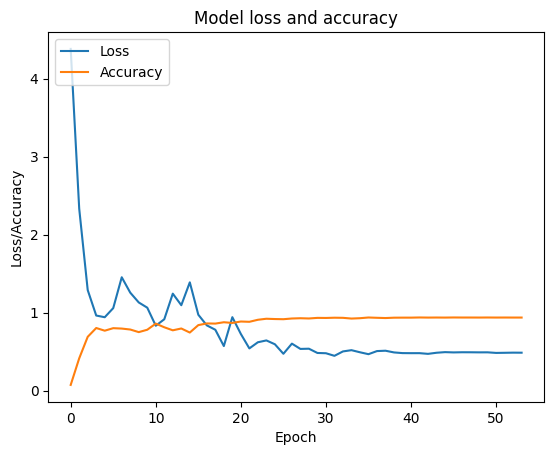

360/360 [==============================] - 18s 50ms/step
57566
11513
2879
57566
11513
2879
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_6 (Batc  (None, 75, 9)            36        
 hNormalization)                                                 
                                                                 
 conv1d_3 (Conv1D)           (None, 73, 64)            1792      
                                                                 
 batch_normalization_7 (Batc  (None, 73, 64)           256       
 hNormalization)                                                 
                                                                 
 gru_3 (GRU)                 (None, 73, 75)            31725     
                                                                 
 batch_normalization_8 (Batc  (None, 73, 75)           300       
 hNormalization)             

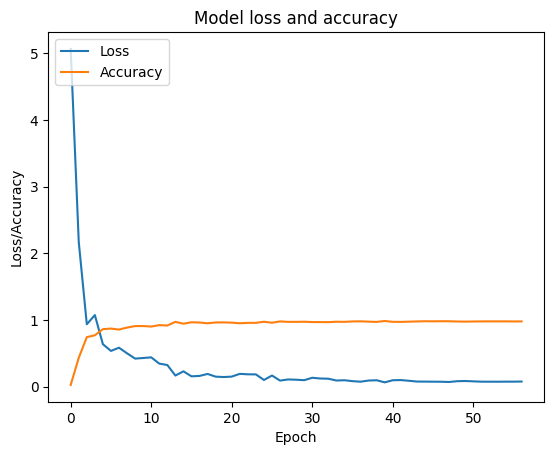

360/360 [==============================] - 19s 53ms/step
57566
11513
2879
57566
11513
2879
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_12 (Bat  (None, 75, 9)            36        
 chNormalization)                                                
                                                                 
 conv1d_6 (Conv1D)           (None, 73, 64)            1792      
                                                                 
 batch_normalization_13 (Bat  (None, 73, 64)           256       
 chNormalization)                                                
                                                                 
 gru_6 (GRU)                 (None, 73, 75)            31725     
                                                                 
 batch_normalization_14 (Bat  (None, 73, 75)           300       
 chNormalization)            

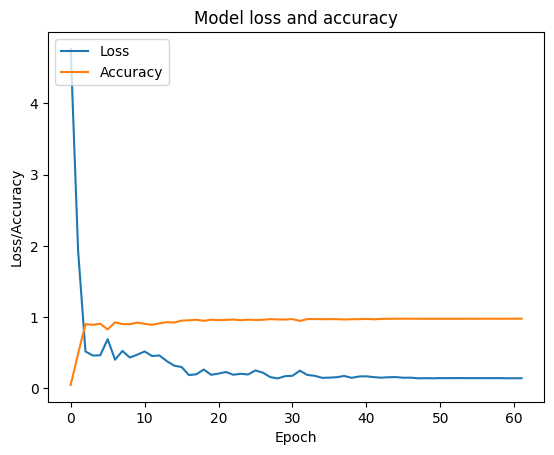

360/360 [==============================] - 18s 50ms/step
57567
11512
2879
57567
11512
2879
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_18 (Bat  (None, 75, 9)            36        
 chNormalization)                                                
                                                                 
 conv1d_9 (Conv1D)           (None, 73, 64)            1792      
                                                                 
 batch_normalization_19 (Bat  (None, 73, 64)           256       
 chNormalization)                                                
                                                                 
 gru_9 (GRU)                 (None, 73, 75)            31725     
                                                                 
 batch_normalization_20 (Bat  (None, 73, 75)           300       
 chNormalization)            

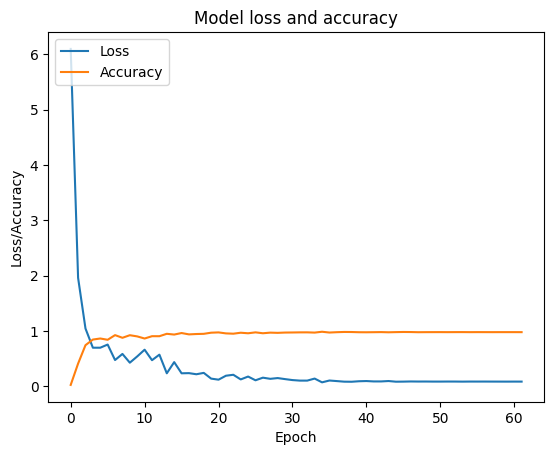

360/360 [==============================] - 19s 51ms/step
57567
11512
2879
57567
11512
2879
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_24 (Bat  (None, 75, 9)            36        
 chNormalization)                                                
                                                                 
 conv1d_12 (Conv1D)          (None, 73, 64)            1792      
                                                                 
 batch_normalization_25 (Bat  (None, 73, 64)           256       
 chNormalization)                                                
                                                                 
 gru_12 (GRU)                (None, 73, 75)            31725     
                                                                 
 batch_normalization_26 (Bat  (None, 73, 75)           300       
 chNormalization)            

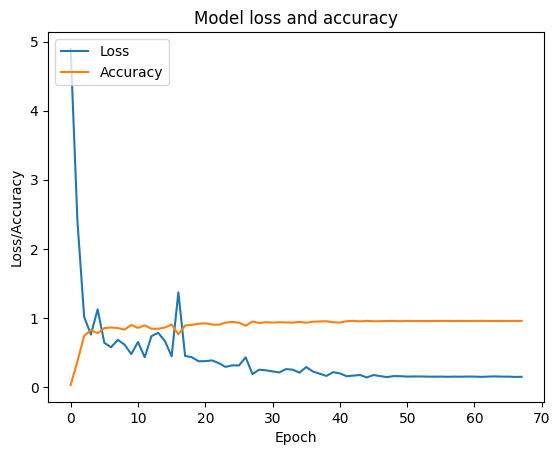

360/360 [==============================] - 19s 51ms/step


In [9]:
# SPLITTING

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X_resh, Y_enc)

test_acc_list =[]
train_acc_list = []
y_int_pred_class = []
y_int_test_class = []


for i, (train_index, test_index) in enumerate(skf.split(X_resh, Y)):

    X_test1 = X_resh[test_index]
    X_train = X_resh[train_index]
    Y_train = Y_enc.iloc[train_index]
    Y_test1 =Y_enc.iloc[test_index]

    X_test, X_val, Y_test, Y_val = train_test_split(X_test1, Y_test1, test_size=0.2, random_state=0, stratify=Y_test1)

    print(X_train.shape[0])
    print(X_test.shape[0])
    print(X_val.shape[0])
    print(Y_train.shape[0])
    print(Y_test.shape[0])
    print(Y_val.shape[0])

    train_dataset = (X_train, Y_train)
    test_dataset = (X_test, Y_test)
    val_dataset = (X_val, Y_val)



#train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
#test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

## MODEL CONSTANTS
    LAYERS = np.dot(1,[75, 75, 75])                # number of units in hidden and output layers
    M_TRAIN = X_train.shape[0]                     # number of training examples (2D)
    M_TEST = X_test.shape[0]                       # number of test examples (2D),full=X_test.shape[0]
    N = X_train.shape[2]                           # number of features
    BATCH = 256                                    # batch size
    EPOCH = 100                                    # number of epochs
    LR = 2e-3                          # learning rate of the gradient descent
    LAMBD = 3e-2                         # lambda in L2 regularizaion
    DP = 0.5                           # dropout rate
    RDP = 0                           # recurrent dropout rate

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    checkpoint = ModelCheckpoint(filepath=log_dir+'/models/'+'model.{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5',
                                 monitor='val_categorical_accuracy',
                                 verbose=1,
                                 save_best_only=True,
                                 save_weights_only=False,
                                 mode='max')

    lr_decay = ReduceLROnPlateau(monitor='loss',
                                 patience=1, verbose=1,
                                 factor=0.5, min_lr=1e-6)

    early_stop = EarlyStopping(monitor='categorical_accuracy', min_delta=0,
                               patience=7, verbose=1, mode='auto',
                               baseline=0, restore_best_weights=True)

    initial_learning_rate = LR
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=100000,
        decay_rate=0.96,
        staircase=True)


    # MODEL DEFINITION
    model = Sequential()
    model.add(layers.Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='sigmoid', input_shape=(75, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.GRU(units=LAYERS[0],
                          activation='selu', recurrent_activation='hard_sigmoid',
                          kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
                          dropout=DP, recurrent_dropout=RDP,
                          return_sequences=True, return_state=False,
                          stateful=False, unroll=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='sigmoid', input_shape=(75, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.GRU(units=LAYERS[1],
                          activation='selu', recurrent_activation='hard_sigmoid',
                          kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
                          dropout=DP, recurrent_dropout=RDP,
                          return_sequences=True, return_state=False,
                          stateful=False, unroll=False))
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='sigmoid', input_shape=(75, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.GRU(units=LAYERS[2],
                          activation='selu', recurrent_activation='hard_sigmoid',
                          kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
                          dropout=DP, recurrent_dropout=RDP,
                          return_sequences=False, return_state=False,
                          stateful=False, unroll=False))
    
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(36, activation='softmax'))

    opt = optimizers.Adam(learning_rate=LR,  clipnorm=1.)



    # MODEL COMPILATION
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['categorical_accuracy'])

    print(model.summary())


    # TRAINING
    history = model.fit(X_train, Y_train, epochs=EPOCH, batch_size=BATCH,
                        shuffle=True,validation_data=val_dataset,
                        callbacks=[
                                    early_stop
                                    ,lr_decay
                                    ,checkpoint
                                    ,tensorboard_callback]
                        )






    # EVALUATION
    # train_loss, train_acc = model.evaluate(X_train, Y_train,
    #                                        batch_size=M_TRAIN, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, Y_test,
                                         batch_size=M_TEST, verbose=0)

    test_acc_list.append(test_acc)
    #train_acc_list.append(train_acc)

    # ACCURACY AND LOSS PLOTS

    print(max(history.history['val_categorical_accuracy']))

    plt.plot(history.history['val_loss'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Model loss and accuracy')
    plt.ylabel('Loss/Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Loss', 'Accuracy'], loc='upper left')
    plt.show()


    y_pred = model.predict(X_test)
    
    
    y_int_pred_class.append(np.argmax(y_pred, axis=1))
    y_int_test_class.append(np.argmax(Y_test.values, axis=1))

    # CONFUSION MATRIX
oh_dict=dict(zip([i for i in range(num_classes)],list(sign_types_dict.keys())))

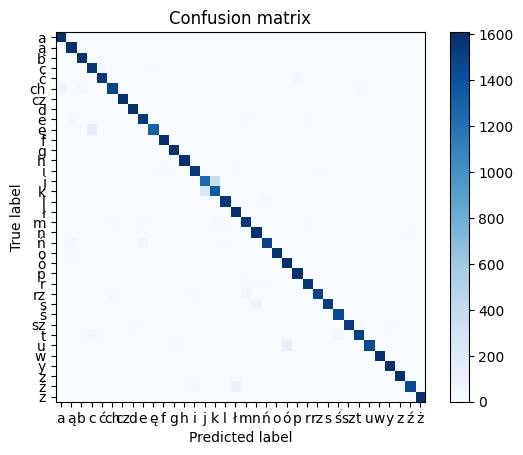

In [10]:
# CONFUSION MATRIX


y_test_class = [oh_dict[i] for i in np.concatenate(y_int_test_class)]
y_pred_class=[oh_dict[i] for i in np.concatenate(y_int_pred_class)]
confusion_mat = confusion_matrix(y_test_class, y_pred_class, labels=list(sign_types_dict.keys()))
plt.imshow(confusion_mat, cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks([cl for cl in range(num_classes)], sign_types_dict.keys())
plt.yticks([cl for cl in range(num_classes)], sign_types_dict.keys())
plt.show()

df_cm = pd.DataFrame(confusion_mat, index=list(sign_types_dict.keys()), columns=list(sign_types_dict.keys()))
cmap = 'PuRd'
#pp_matrix(df_cm, cmap=cmap)

# tf.math.confusion_matrix(Y_test,y_pred)
# #%%
# # ROC PLOT
# fpr = {}
# tpr = {}
# roc_auc = {}
#
# for i in range(3):
#     fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_pred[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])
#
# plt.figure()
# for i in range(3):
#     plt.plot(fpr[i], tpr[i], label='ROC curve for class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC curves for all classes')
# plt.legend(loc="lower right")
# plt.show()

In [11]:
np.average(test_acc_list)

0.963379418849945